In [2]:
import os
from functools import reduce 
from glob import glob
from multiprocessing import Pool

from matplotlib import pyplot as plt
from scipy.sparse import bsr_matrix
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

%matplotlib inline

# Grid in GPS Coordinates

In [3]:
pd.read_parquet('./parquet/2020/sg_taxi_20200324.parquet').head()

,lon,lat
ts,,
2020-03-23 23:59:53+08:00,103.62149,1.27630
2020-03-23 23:59:53+08:00,103.62701,1.30270
2020-03-23 23:59:53+08:00,103.62800,1.29908
2020-03-23 23:59:53+08:00,103.63140,1.31135
2020-03-23 23:59:53+08:00,103.63279,1.32907


In [4]:
def parquet_to_matrix(parquet_path, decimal_precision, persist_dir):
    pd\
        .read_parquet(parquet_path)\
        .assign(grid_lon=lambda df: df.lon.round(decimal_precision), 
                grid_lat=lambda df: df.lat.round(decimal_precision))\
        .groupby(['grid_lat', 'grid_lon'])\
        .size()\
        .rename('num')\
        .reset_index()\
        .to_parquet(os.path.join(persist_dir, 'grid_%s' % os.path.basename(parquet_path)), compression='gzip')

    
parquet_to_matrix(persist_dir='./grid',
                  parquet_path='./parquet/2018/sg_taxi_20180319.parquet', 
                  decimal_precision=4)

In [5]:
pd.read_parquet('./grid/grid_sg_taxi_20180319.parquet')

,grid_lat,grid_lon,num
0,1.2336,103.6756,1
1,1.2337,103.6760,1
2,1.2338,103.6757,7
3,1.2338,103.6758,2
4,1.2339,103.6758,2
...,...,...,...
722216,1.4694,103.8116,1
722217,1.4694,103.8118,2
722218,1.4695,103.8142,1
722219,1.4697,103.8141,1


In [6]:
def _mp(args):
    try:
        parquet_path, decimal_precision, persist_dir = args
        parquet_to_matrix(persist_dir=persist_dir, parquet_path=parquet_path, decimal_precision=decimal_precision)
    except Exception as e:
        print(parquet_path, e)

In [7]:
def persist_multiple_parquets_to_matrix(parquet_paths, decimal_precision, dir_persist):
    filtered_paths = list(filter(lambda path: not os.path.exists(os.path.join(dir_persist, 'grid_%s' % os.path.basename(path))), parquet_paths))
    with Pool(maxtasksperchild=1) as pool:
        for none_res in tqdm(pool.imap_unordered(
                      _mp, 
                      [(path, decimal_precision, dir_persist) for path in filtered_paths]
                  ), total=len(filtered_paths)):
            pass

In [8]:
# persist_multiple_parquets_to_matrix(
#     dir_persist='./grid',
#     parquet_paths=glob('./parquet/*/*.parquet'), 
#     decimal_precision=4)

In [9]:
def sum_up_grid(grid_dir):
    tasks =  glob(os.path.join(grid_dir, '*'))
    return reduce(lambda ser1, ser2: ser1.add(ser2, fill_value=0), 
                  tqdm(
                      (pd.read_parquet(f).set_index(['grid_lat', 'grid_lon']).squeeze() 
                      for f in tasks), 
                  total=len(tasks)))

# sum_up_grid(grid_dir='./grid').to_csv('./df_grid.csv')

In [10]:
df_grid = pd.read_csv('./df_grid.csv')[lambda df: (df.grid_lat.between(1, 2)) & (df.grid_lon.between(100, 105))]
print('Total observations: %g' % df_grid.num.sum())
df_grid.describe()

Total observations: 1.20339e+10


,grid_lat,grid_lon,num
count,2.672436e+06,2.672436e+06,2.672436e+06
mean,1.348823e+00,1.038235e+02,4.502961e+03
std,4.589089e-02,8.331047e-02,2.467958e+04
min,1.231600e+00,1.036132e+02,1.000000e+00
25%,1.315900e+00,1.037659e+02,1.700000e+01
50%,1.341400e+00,1.038302e+02,2.390000e+02
75%,1.378100e+00,1.038834e+02,2.414000e+03
max,1.470300e+00,1.040218e+02,9.506609e+06


In [11]:
bbox = {'lat_min': df_grid.grid_lat.min(), 
        'lon_min': df_grid.grid_lon.min(), 
        'lat_max': df_grid.grid_lat.max(), 
        'lon_max': df_grid.grid_lon.max()}
bbox

{'lat_min': 1.2316,
 'lon_min': 103.6132,
 'lat_max': 1.4703,
 'lon_max': 104.0218}

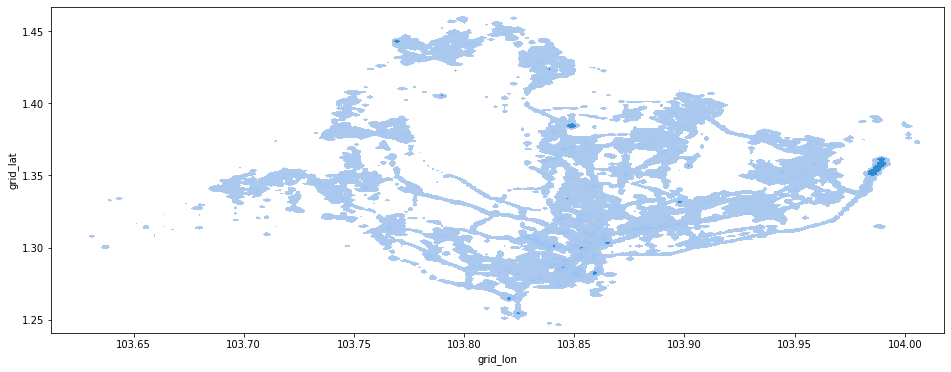

In [40]:
import seaborn as sns

def plot(df_grid):
    fig, ax = plt.subplots(figsize=(16, 6))
    return sns.kdeplot(
        bw_adjust=0.05,
        ax=ax, 
        data=df_grid[lambda df: (df.num / df.num.max()) > 1E-3], 
        y='grid_lat', 
        x='grid_lon', 
        weights='num', 
        fill=True)

plot(df_grid=df_grid)